## Naomi, Parshana, Sinchana, Joanna

In [62]:
%pip install pandas numpy matplotlib scikit-learn keras tensorflow nltk


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joannachou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joannachou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/joannachou/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## TASK 1 - EDA

### Question 1

In [64]:
df_main = pd.read_csv("S19_All_Release_2_10_22/Data/MainTable.csv")
df_subj = pd.read_csv("S19_All_Release_2_10_22/Data/LinkTables/Subject.csv")
df_problems = pd.read_csv("2nd CSEDM Data Challenge - Problem Prompts & Concepts Used - Sheet1.CSV")

In [65]:
# Number of unique students - using MainTable.csv
len(df_main['SubjectID'].unique())

413

In [66]:
# Number of unique students - using LinkTables/Subject.csv
len(df_subj['SubjectID'].unique())
# Less because some people did not take the final

372

### Question 2

In [67]:
df_early = pd.read_csv("S19_All_Release_2_10_22/early.csv")
df_late = pd.read_csv("S19_All_Release_2_10_22/late.csv")
df_all = pd.concat([df_early, df_late])

In [68]:
mean_attempts = df_all.groupby(['AssignmentID', 'ProblemID'])['Attempts'].mean()
mean_attempts.head()
print(f"Assignment {mean_attempts.idxmax()[0]} Problem {mean_attempts.idxmax()[1]} had the most attempts at {mean_attempts.max()}.")

Assignment 487.0 Problem 102 had the most attempts at 10.422535211267606.


### Question 3

In [69]:
df_main = pd.read_csv("S19_All_Release_2_10_22/Data/MainTable.csv")
df_compile = df_main[df_main['EventType'] == "Compile"]

In [70]:
compile_errors = df_compile[df_compile['Compile.Result'] == 'Error']
grouped_compile_errors = compile_errors.groupby(['AssignmentID', 'ProblemID'])['Compile.Result'].size()
print(f"Assignment {grouped_compile_errors.idxmax()[0]} Problem {grouped_compile_errors.idxmax()[1]} had the most compile errors at {grouped_compile_errors.max()}.")

Assignment 439.0 Problem 13 had the most compile errors at 2440.


Computing the total number of compiler errors faced on each problem, and report the maximum is more meaningful because it directly answers which problems had the most compile errors from all students. This is more meaningful for knowing which problems students as a whole struggled with compiling.

## Task 2 - Open-Ended Analysis

### Analyzing frequency of errors changing over time

In [71]:
messages = df_main[df_main['EventType'] == "Compile.Error"][['ServerTimestamp','AssignmentID', 'ProblemID', 'CompileMessageData']]

messages['ServerTimestamp'] = pd.to_datetime(messages['ServerTimestamp'])
messages['Date'] = messages['ServerTimestamp'].dt.date

In [72]:
messages['CompileMessageData'] = messages['CompileMessageData'].apply(
    lambda x: re.sub(r"line \d+: (error: |\[empty\])?", "", x)
)
messages

ServerTimestamp  AssignmentID  ProblemID  \
14     2019-02-24 04:27:49         439.0         13   
15     2019-02-24 04:27:49         439.0         13   
16     2019-02-24 04:27:49         439.0         13   
17     2019-02-24 04:27:49         439.0         13   
20     2019-02-24 04:29:44         439.0         13   
...                    ...           ...        ...   
201541 2019-05-05 21:37:37         502.0         48   
201542 2019-05-05 21:37:37         502.0         48   
201549 2019-05-05 23:26:16         502.0         56   
201556 2019-05-05 23:36:39         502.0         64   
201561 2019-05-05 23:41:41         502.0         70   

                                       CompileMessageData        Date  
14                          illegal start of expression.   2019-02-24  
15                          illegal start of expression.   2019-02-24  
16                          illegal start of expression.   2019-02-24  
17                            illegal start of expression  2019-02-24  
20                               missing return statement  2019-02-24  
...                                                   ...         ...  
201541  variable r is already defined in method withou...  2019-05-05  
201542                     cannot find symbol: variable i  2019-05-05  
201549                   cannot find symbol: variable min  2019-05-05  
201556                 cannot find symbol: variable array  2019-05-05  
201561                 cannot find symbol: variable state  2019-05-05  

[62316 rows x 5 columns]

CCategorize compile error messages into different types:

In [73]:
def categorize_error(msg):
    # Syntax Error
    if re.search(r"(illegal|cannot find symbol|character literal|illegal start of|illegal escape character|illegal character|unclosed string literal|illegal line end in character literal|invalid method declaration; return type required\.|array dimension missing|bad operand type int for unary operator '!'|bad initializer for for-loop|array required, but int found|no suitable constructor found for String\(char\)|not a statement|missing return statement|integer number too large)", msg, re.IGNORECASE):
        return "Syntax Error"
    # Type Error
    elif re.search(r"(bad operand type|dereferenced|type not allowed|unexpected type|char cannot be dereferenced|incompatible types|incomparable types|cannot be converted|bad operand types|int cannot be dereferenced|array dimension missing|incomparable types: boolean and int)", msg, re.IGNORECASE):
        return "Type Error"
    # Variable/Method not found
    elif re.search(r"(variable .+ is already defined|cannot assign a value to final variable|cannot assign a value to final variable this|cannot find symbol: method|cannot find symbol: variable|cannot find symbol: class)", msg, re.IGNORECASE):
        return "Variable/Method not found"
    # Initialization Issues
    elif re.search(r"(variable declaration not allowed here|variable .+ might not have been initialized|invalid method declaration|class expected|class .+ is already defined)", msg, re.IGNORECASE):
        return "Initialization Issues"
    # Control Flow
    elif re.search(r"(for-each not applicable to expression type|orphaned case|break outside switch or loop|unreachable statement|'else' without 'if'|reached end of file|empty statement after if|'finally' without 'try'|return outside method|while expected)", msg, re.IGNORECASE):
        return "Control Flow"
    # Class/Interface declaration
    elif re.search(r"(class, interface, or enum expected)", msg, re.IGNORECASE):
        return "Class/Interface declaration"
    # Method Argument Errors
    elif re.search(r"(required, but|missing method|method .+ already defined|method .+ cannot be applied to given types|no arguments|no suitable method found)", msg, re.IGNORECASE):
        return("Method Argument")
    # Character expected
    elif re.search(r"(: expected|';' expected|'\)' expected|'\]' expected|'\[' expected|'\(' expected|; expected|> expected|' expected)", msg, re.IGNORECASE):
        return("Char Expected")
    else:
        return "Other"
messages['ErrorCategory'] = messages['CompileMessageData'].apply(categorize_error)

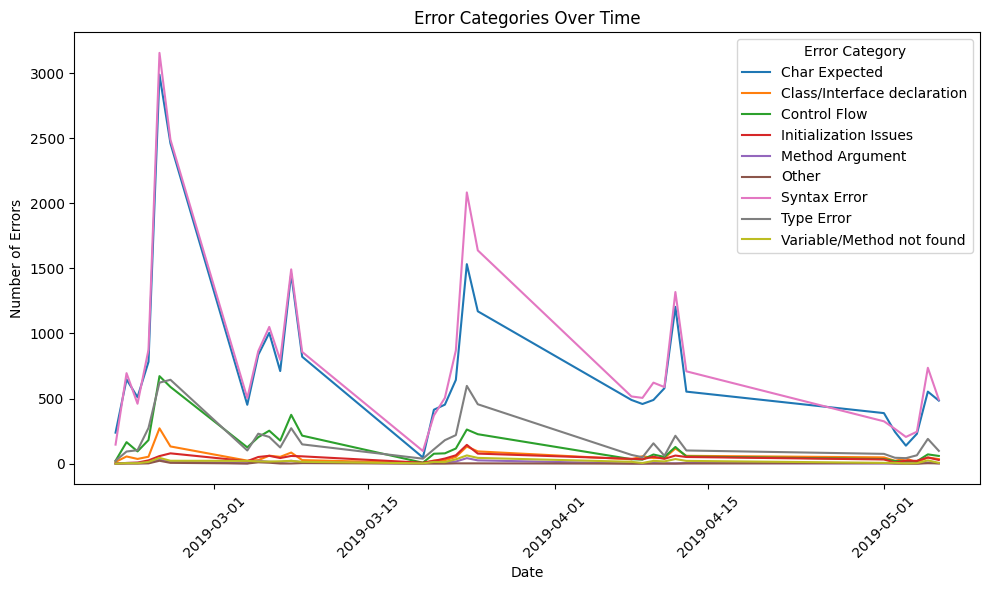

In [74]:
error_counts = messages.groupby(['Date', 'ErrorCategory']).size().unstack(fill_value=0)

# Plotting the line graph
plt.figure(figsize=(10, 6))
for category in error_counts.columns:
    plt.plot(error_counts.index, error_counts[category], label=category)

plt.xlabel('Date')
plt.ylabel('Number of Errors')
plt.title('Error Categories Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Error Category')
plt.tight_layout()
plt.show()

We see spikes in errors presumably when an assignment is due, and students are compiling their code more often before the due date. The syntax errors and char expected errors are significantly higher than other types of errors. This is expected since novice programmers likely haven’t written enough code to check syntax thoroughly before compiling. Even advanced programmers forget a semicolon every now and then. Char expected errors also go hand in hand with syntax errors and can be linked to the same cause. 

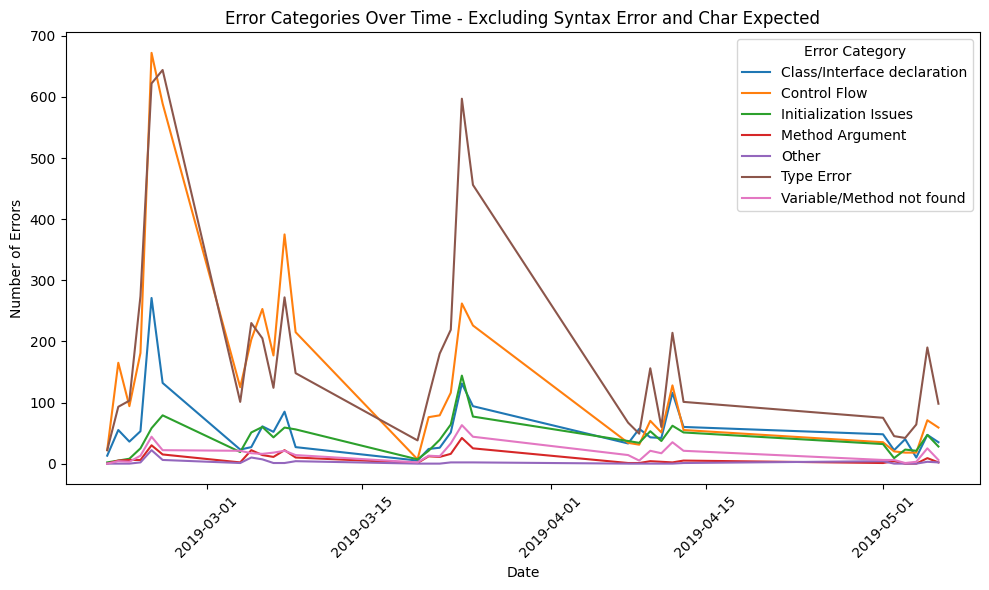

In [75]:
exclude_messages = messages[~messages['ErrorCategory'].isin(['Syntax Error', 'Char Expected'])]
error_counts_excluded = exclude_messages.groupby(['Date', 'ErrorCategory']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
for category in error_counts_excluded.columns:
    plt.plot(error_counts_excluded.index, error_counts_excluded[category], label=category)

plt.xlabel('Date')
plt.ylabel('Number of Errors')
plt.title('Error Categories Over Time - Excluding Syntax Error and Char Expected')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Error Category')
plt.tight_layout()
plt.show()

This graph is the same as the one above, but without syntax and char expected errors, which were an overwhelming majority, clouding our analysis. We now see a new trend in control flow and type errors. However, only type errors spike halfway through the term in this graph. This can be compared with lecture material and lab assignments to find out which assignment in particular cause confusion among students. We can hypothesize that there might have been new types introduced that the students struggled with. All of the other types of errors are relatively low but they do not necessarily decrease as the term goes on. In fact, they get higher midway through, then drop low again. This leads us to believe that there was either a very challenging assignment halfway through the quarter, or some new concept was introduced that really altered the students’ understanding of concepts they excelled at before. 


### Predicting Score from problem features

In [76]:
df_subj

SubjectID  X-Grade
0    65be44ae7088566069cc3bef454174a7   0.3600
1    0bdf2c1f053650715e1f0c725d754b96   0.3917
2    ad8d3a0a0f0a084a97fad357c649438c   0.6160
3    f4db8537e9d75da46c4efc36a2d70956   0.4310
4    d7419ae04f248e5105ac3d0700389775   0.7244
..                                ...      ...
368  e2d083a5fd066b082d93042169313e21   0.6800
369  2e667fca5e24ac13dcee94ddc4aa751a   0.0000
370  65a5e77645ee9f1918165a0a8c503297   0.0000
371  c8720c9e82b818798e7b391fd62adf33   0.9200
372  901e70da072bc616caa6337421abe4ae   0.0000

[373 rows x 2 columns]

In [77]:
df_main

Order                         SubjectID        ToolInstances  \
0       119630  00c54f9462673d4c09d2a88121860841  Java 8; CodeWorkout   
1       119631  00c54f9462673d4c09d2a88121860841  Java 8; CodeWorkout   
2       134330  00c54f9462673d4c09d2a88121860841  Java 8; CodeWorkout   
3       134331  00c54f9462673d4c09d2a88121860841  Java 8; CodeWorkout   
4        65666  00c54f9462673d4c09d2a88121860841  Java 8; CodeWorkout   
...        ...                               ...                  ...   
201565  108283  ffb72475a81de0e95b910ffad039f5c2  Java 8; CodeWorkout   
201566  110202  ffb72475a81de0e95b910ffad039f5c2  Java 8; CodeWorkout   
201567  110203  ffb72475a81de0e95b910ffad039f5c2  Java 8; CodeWorkout   
201568   81273  ffb72475a81de0e95b910ffad039f5c2  Java 8; CodeWorkout   
201569   81274  ffb72475a81de0e95b910ffad039f5c2  Java 8; CodeWorkout   

            ServerTimestamp ServerTimezone CourseID  CourseSectionID  \
0       2019-02-24T05:13:03            UTC     CS 1                1   
1       2019-02-24T05:13:03            UTC     CS 1                1   
2       2019-02-24T05:13:33              0     CS 1                1   
3       2019-02-24T05:13:33              0     CS 1                1   
4       2019-02-24T05:09:54            UTC     CS 1                1   
...                     ...            ...      ...              ...   
201565  2019-05-05T23:46:43              0     CS 1                1   
201566  2019-05-05T23:50:16              0     CS 1                1   
201567  2019-05-05T23:50:16              0     CS 1                1   
201568  2019-05-06T00:02:36              0     CS 1                1   
201569  2019-05-06T00:02:36              0     CS 1                1   

        AssignmentID  ProblemID                               CodeStateID  \
0              439.0          1  efdf3fae54cdc0a09fb81fcfa365c5f843e837b0   
1              439.0          1  efdf3fae54cdc0a09fb81fcfa365c5f843e837b0   
2              439.0          3  79b2bcc8f502e1f7d2d4e83d1894964684c89b85   
3              439.0          3  79b2bcc8f502e1f7d2d4e83d1894964684c89b85   
4              439.0          5  2697d299e7c5992f557ce38d8a04345112a11af8   
...              ...        ...                                       ...   
201565         502.0         71  9e7128eff25bb3a3a9860fa47cfe100c08f31f58   
201566         502.0        112  6f094eec8e43a75c47ef236a487cc76442cc7b7b   
201567         502.0        112  6f094eec8e43a75c47ef236a487cc76442cc7b7b   
201568         502.0        118  899f7092e7960366de80fdfca077387ac5c26a04   
201569         502.0        118  899f7092e7960366de80fdfca077387ac5c26a04   

        IsEventOrderingConsistent    EventType  Score Compile.Result  \
0                            True  Run.Program   1.00            NaN   
1                            True      Compile    NaN        Success   
2                            True  Run.Program   1.00            NaN   
3                            True      Compile    NaN        Success   
4                            True  Run.Program   0.75            NaN   
...                           ...          ...    ...            ...   
201565                       True      Compile    NaN        Success   
201566                       True  Run.Program   1.00            NaN   
201567                       True      Compile    NaN        Success   
201568                       True  Run.Program   1.00            NaN   
201569                       True      Compile    NaN        Success   

       CompileMessageType CompileMessageData   EventID ParentEventID  \
0                     NaN                NaN   1-69176           NaN   
1                     NaN                NaN   1-69177       1-69176   
2                     NaN                NaN   3-68089           NaN   
3                     NaN                NaN   3-68090       3-68089   
4                     NaN                NaN   5-35681           NaN   
...                   ...                ... 

In [78]:
df_score = df_main[df_main['EventType'] == "Run.Program"]
df_score = df_score.groupby(['SubjectID', 'AssignmentID', 'ProblemID'])['Score'].max().reset_index()
df_score.head()

SubjectID  AssignmentID  ProblemID  Score
0  00c54f9462673d4c09d2a88121860841         439.0          1    1.0
1  00c54f9462673d4c09d2a88121860841         439.0          3    1.0
2  00c54f9462673d4c09d2a88121860841         439.0          5    1.0
3  00c54f9462673d4c09d2a88121860841         439.0         12    1.0
4  00c54f9462673d4c09d2a88121860841         439.0         13    1.0

In [79]:
score_problems = pd.merge(df_score, df_problems, on=['AssignmentID', 'ProblemID'], how='inner')
score_problems.head()

SubjectID  AssignmentID  ProblemID  Score  \
0  00c54f9462673d4c09d2a88121860841         439.0          1    1.0   
1  00c54f9462673d4c09d2a88121860841         439.0          3    1.0   
2  00c54f9462673d4c09d2a88121860841         439.0          5    1.0   
3  00c54f9462673d4c09d2a88121860841         439.0         12    1.0   
4  00c54f9462673d4c09d2a88121860841         439.0         13    1.0   

                                         Requirement  If/Else  NestedIf  \
0  Write a function in Java that implements the f...      1.0       NaN   
1  Write a function in Java that implements the f...      1.0       1.0   
2  Write a function in Java that implements the f...      1.0       1.0   
3  Write a function in Java that implements the f...      1.0       1.0   
4  Write a function in Java that implements the f...      1.0       1.0   

   While  For  NestedFor  ...  LogicCompareNum  LogicBoolean  StringFormat  \
0    NaN  NaN        NaN  ...              1.0           NaN           NaN   
1    NaN  NaN        NaN  ...              1.0           1.0           NaN   
2    NaN  NaN        NaN  ...              NaN           1.0           NaN   
3    NaN  NaN        NaN  ...              1.0           1.0           NaN   
4    NaN  NaN        NaN  ...              1.0           1.0           NaN   

   StringConcat  StringIndex  StringLen  StringEqual  CharEqual  ArrayIndex  \
0           NaN          NaN        NaN          NaN        NaN         NaN   
1           NaN          NaN        NaN          NaN        NaN         NaN   
2           NaN          NaN        NaN          NaN        NaN         NaN   
3           NaN          NaN        NaN          NaN        NaN         NaN   
4           NaN          NaN        NaN          NaN        NaN         NaN   

   DefFunction  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 23 columns]

In [80]:
df_all

SubjectID  AssignmentID  ProblemID  Attempts  \
0     036ad3e516c5bf3a4b3be35b137bcbb8         439.0          1         8   
1     036ad3e516c5bf3a4b3be35b137bcbb8         439.0          3         6   
2     036ad3e516c5bf3a4b3be35b137bcbb8         439.0          5         7   
3     036ad3e516c5bf3a4b3be35b137bcbb8         439.0         12         2   
4     036ad3e516c5bf3a4b3be35b137bcbb8         439.0         13        17   
...                                ...           ...        ...       ...   
5717  ffb72475a81de0e95b910ffad039f5c2         502.0         64         2   
5718  ffb72475a81de0e95b910ffad039f5c2         502.0         70         2   
5719  ffb72475a81de0e95b910ffad039f5c2         502.0         71         1   
5720  ffb72475a81de0e95b910ffad039f5c2         502.0        112         1   
5721  ffb72475a81de0e95b910ffad039f5c2         502.0        118         1   

      CorrectEventually  Label  
0                  True  False  
1                  True  False  
2                  True  False  
3                  True   True  
4                  True  False  
...                 ...    ...  
5717               True   True  
5718               True   True  
5719               True   True  
5720               True   True  
5721               True   True  

[14828 rows x 6 columns]

In [81]:
df_problems.head()

AssignmentID  ProblemID                                        Requirement  \
0           439          1  Write a function in Java that implements the f...   
1           439          3  Write a function in Java that implements the f...   
2           439          5  Write a function in Java that implements the f...   
3           439         12  Write a function in Java that implements the f...   
4           439         13  Write a function in Java that implements the f...   

   If/Else  NestedIf  While  For  NestedFor  Math+-*/  Math%  ...  \
0      1.0       NaN    NaN  NaN        NaN       1.0    NaN  ...   
1      1.0       1.0    NaN  NaN        NaN       NaN    NaN  ...   
2      1.0       1.0    NaN  NaN        NaN       NaN    NaN  ...   
3      1.0       1.0    NaN  NaN        NaN       NaN    NaN  ...   
4      1.0       1.0    NaN  NaN        NaN       1.0    NaN  ...   

   LogicCompareNum  LogicBoolean  StringFormat  StringConcat  StringIndex  \
0              1.0           NaN           NaN           NaN          NaN   
1              1.0           1.0           NaN           NaN          NaN   
2              NaN           1.0           NaN           NaN          NaN   
3              1.0           1.0           NaN           NaN          NaN   
4              1.0           1.0           NaN           NaN          NaN   

   StringLen  StringEqual  CharEqual  ArrayIndex  DefFunction  
0        NaN          NaN        NaN         NaN          NaN  
1        NaN          NaN        NaN         NaN          NaN  
2        NaN          NaN        NaN         NaN          NaN  
3        NaN          NaN        NaN         NaN          NaN  
4        NaN          NaN        NaN         NaN          NaN  

[5 rows x 21 columns]

In [82]:
## collapse to one row per student by averaging the number of attempts per problem

df_grades = pd.merge(df_score, df_all, on=['SubjectID', 'AssignmentID', 'ProblemID'], how='inner')
#df_grades = df_grades.groupby(['SubjectID', 'AssignmentID', 'ProblemID'])[['Attempts', 'Score']].max()
df_grades = pd.merge(df_grades, df_subj, on=['SubjectID'], how='inner')
df_grades = pd.merge(df_grades, df_problems, on=['AssignmentID', 'ProblemID'], how='inner')
df_grades.columns

Index(['SubjectID', 'AssignmentID', 'ProblemID', 'Score', 'Attempts',
       'CorrectEventually', 'Label', 'X-Grade', 'Requirement', 'If/Else',
       'NestedIf', 'While', 'For', 'NestedFor', 'Math+-*/', 'Math%',
       'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean', 'StringFormat',
       'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual',
       'ArrayIndex', 'DefFunction'],
      dtype='object')

In [83]:
important_columns = ['SubjectID', 'AssignmentID', 'ProblemID', 'Attempts', 'Score', 'X-Grade','Requirement', 'If/Else',
       'NestedIf', 'While', 'For', 'NestedFor', 'Math+-*/', 'Math%',
       'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean', 'StringFormat',
       'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual',
       'ArrayIndex', 'DefFunction']

In [84]:
df_model = df_grades[important_columns]
df_model.head()
df_max = df_model.loc[df_model.groupby(['SubjectID', 'AssignmentID', 'ProblemID'])['Score'].idxmax()]
df_max.head()

SubjectID  AssignmentID  ProblemID  Attempts  Score  \
0  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          1         8    1.0   
1  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          3         6    1.0   
2  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          5         7    1.0   
3  036ad3e516c5bf3a4b3be35b137bcbb8         439.0         12         2    1.0   
4  036ad3e516c5bf3a4b3be35b137bcbb8         439.0         13        17    1.0   

   X-Grade                                        Requirement  If/Else  \
0    0.772  Write a function in Java that implements the f...      1.0   
1    0.772  Write a function in Java that implements the f...      1.0   
2    0.772  Write a function in Java that implements the f...      1.0   
3    0.772  Write a function in Java that implements the f...      1.0   
4    0.772  Write a function in Java that implements the f...      1.0   

   NestedIf  While  ...  LogicCompareNum  LogicBoolean  StringFormat  \
0       NaN    NaN  ...              1.0           NaN           NaN   
1       1.0    NaN  ...              1.0           1.0           NaN   
2       1.0    NaN  ...              NaN           1.0           NaN   
3       1.0    NaN  ...              1.0           1.0           NaN   
4       1.0    NaN  ...              1.0           1.0           NaN   

   StringConcat  StringIndex  StringLen  StringEqual  CharEqual  ArrayIndex  \
0           NaN          NaN        NaN          NaN        NaN         NaN   
1           NaN          NaN        NaN          NaN        NaN         NaN   
2           NaN          NaN        NaN          NaN        NaN         NaN   
3           NaN          NaN        NaN          NaN        NaN         NaN   
4           NaN          NaN        NaN          NaN        NaN         NaN   

   DefFunction  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [85]:
df_max.columns

Index(['SubjectID', 'AssignmentID', 'ProblemID', 'Attempts', 'Score',
       'X-Grade', 'Requirement', 'If/Else', 'NestedIf', 'While', 'For',
       'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr', 'LogicCompareNum',
       'LogicBoolean', 'StringFormat', 'StringConcat', 'StringIndex',
       'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex', 'DefFunction'],
      dtype='object')

In [86]:
def replace_problem_details_with_score(df):
    problem_detail_cols = ['If/Else', 'NestedIf', 'While', 'For',
       'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr', 'LogicCompareNum',
       'LogicBoolean', 'StringFormat', 'StringConcat', 'StringIndex',
       'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex', 'DefFunction']

    for col in problem_detail_cols:
        df[col] = df.apply(lambda row: row['Score'] if row[col] == 1 else row[col], axis=1)
    
    return df

df_updated = replace_problem_details_with_score(df_max)

df_updated.head()

SubjectID  AssignmentID  ProblemID  Attempts  Score  \
0  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          1         8    1.0   
1  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          3         6    1.0   
2  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          5         7    1.0   
3  036ad3e516c5bf3a4b3be35b137bcbb8         439.0         12         2    1.0   
4  036ad3e516c5bf3a4b3be35b137bcbb8         439.0         13        17    1.0   

   X-Grade                                        Requirement  If/Else  \
0    0.772  Write a function in Java that implements the f...      1.0   
1    0.772  Write a function in Java that implements the f...      1.0   
2    0.772  Write a function in Java that implements the f...      1.0   
3    0.772  Write a function in Java that implements the f...      1.0   
4    0.772  Write a function in Java that implements the f...      1.0   

   NestedIf  While  ...  LogicCompareNum  LogicBoolean  StringFormat  \
0       NaN    NaN  ...              1.0           NaN           NaN   
1       1.0    NaN  ...              1.0           1.0           NaN   
2       1.0    NaN  ...              NaN           1.0           NaN   
3       1.0    NaN  ...              1.0           1.0           NaN   
4       1.0    NaN  ...              1.0           1.0           NaN   

   StringConcat  StringIndex  StringLen  StringEqual  CharEqual  ArrayIndex  \
0           NaN          NaN        NaN          NaN        NaN         NaN   
1           NaN          NaN        NaN          NaN        NaN         NaN   
2           NaN          NaN        NaN          NaN        NaN         NaN   
3           NaN          NaN        NaN          NaN        NaN         NaN   
4           NaN          NaN        NaN          NaN        NaN         NaN   

   DefFunction  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [87]:
df_model = df_updated.groupby(['SubjectID', 'X-Grade'])[['If/Else',
       'NestedIf', 'While', 'For', 'NestedFor', 'Math+-*/', 'Math%',
       'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean', 'StringFormat',
       'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual',
       'ArrayIndex', 'DefFunction']].mean()

In [88]:
df_model.head()

If/Else  NestedIf     While  For  \
SubjectID                        X-Grade                                      
036ad3e516c5bf3a4b3be35b137bcbb8 0.7720   1.000000       1.0  1.000000  1.0   
04c32d4d95425f73b3a1d6502aed4d48 0.7060   1.000000       1.0  1.000000  1.0   
0503bf609757acf2e75aa8cbc0d8323b 0.7617   1.000000       1.0  1.000000  1.0   
06d801cb636235b298c40029ad9921e7 0.8800   1.000000       1.0  1.000000  1.0   
07ae4cca3f90a49347ccb5c1a82ff46f 0.8400   0.998182       1.0  0.973333  1.0   

                                          NestedFor  Math+-*/  Math%  \
SubjectID                        X-Grade                               
036ad3e516c5bf3a4b3be35b137bcbb8 0.7720         1.0     1.000    1.0   
04c32d4d95425f73b3a1d6502aed4d48 0.7060         1.0     1.000    1.0   
0503bf609757acf2e75aa8cbc0d8323b 0.7617         1.0     1.000    1.0   
06d801cb636235b298c40029ad9921e7 0.8800         1.0     1.000    1.0   
07ae4cca3f90a49347ccb5c1a82ff46f 0.8400         1.0     0.996    1.0   

                                          LogicAndNotOr  LogicCompareNum  \
SubjectID                        X-Grade                                   
036ad3e516c5bf3a4b3be35b137bcbb8 0.7720        1.000000         1.000000   
04c32d4d95425f73b3a1d6502aed4d48 0.7060        1.000000         1.000000   
0503bf609757acf2e75aa8cbc0d8323b 0.7617        1.000000         1.000000   
06d801cb636235b298c40029ad9921e7 0.8800        1.000000         1.000000   
07ae4cca3f90a49347ccb5c1a82ff46f 0.8400        0.997333         0.997949   

                                          LogicBoolean  StringFormat  \
SubjectID                        X-Grade                               
036ad3e516c5bf3a4b3be35b137bcbb8 0.7720            1.0           1.0   
04c32d4d95425f73b3a1d6502aed4d48 0.7060            1.0           1.0   
0503bf609757acf2e75aa8cbc0d8323b 0.7617            1.0           1.0   
06d801cb636235b298c40029ad9921e7 0.8800            1.0           1.0   
07ae4cca3f90a49347ccb5c1a82ff46f 0.8400            1.0           1.0   

                                          StringConcat  StringIndex  \
SubjectID                        X-Grade                              
036ad3e516c5bf3a4b3be35b137bcbb8 0.7720            1.0          1.0   
04c32d4d95425f73b3a1d6502aed4d48 0.7060            1.0          1.0   
0503bf609757acf2e75aa8cbc0d8323b 0.7617            1.0          1.0   
06d801cb636235b298c40029ad9921e7 0.8800            1.0          1.0   
07ae4cca3f90a49347ccb5c1a82ff46f 0.8400            1.0          1.0   

                                          StringLen  StringEqual  CharEqual  \
SubjectID                        X-Grade                                      
036ad3e516c5bf3a4b3be35b137bcbb8 0.7720         1.0          1.0        1.0   
04c32d4d95425f73b3a1d6502aed4d48 0.7060         1.0          1.0        1.0   
0503bf609757acf2e75aa8cbc0d8323b 0.7617         1.0          1.0        1.0   
06d801cb636235b298c40029ad9921e7 0.8800         1.0          1.0        1.0   
07ae4cca3f90a49347ccb5c1a82ff46f 0.8400         1.0          1.0        1.0   

                                          ArrayIndex  DefFunction  
SubjectID                        X-Grade                           
036ad3e516c5bf3a4b3be35b137bcbb8 0.7720          1.0          1.0  
04c32d4d95425f73b3a1d6502aed4d48 0.7060          1.0          1.0  
0503bf609757acf2e75aa8cbc0d8323b 0.7617          1.0          NaN  
06d801cb636235b298c40029ad9921e7 0.8800          1.0          NaN  
07ae4cca3f90a49347ccb5c1a82ff46f 0.8400          1.0          1.0

## Start building the model (s)

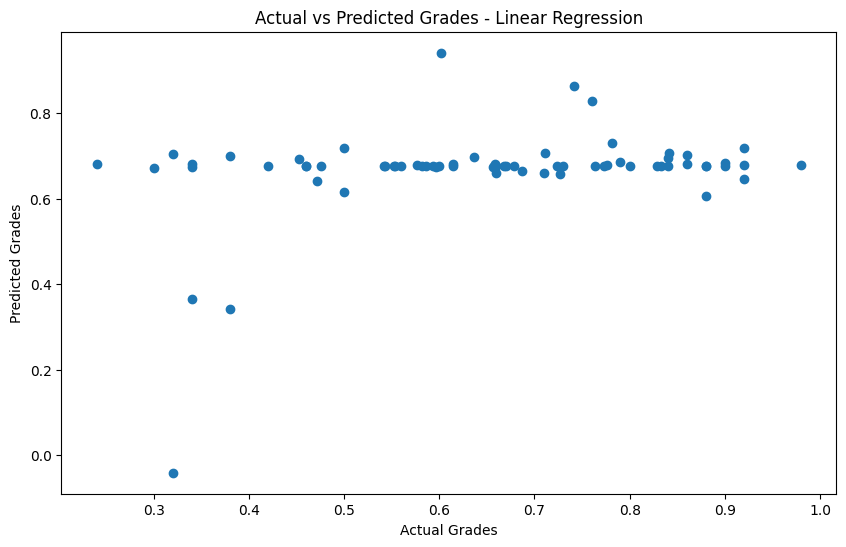

Root Mean Squared Error: 0.18225271774118887


In [89]:
df_model = df_model.fillna(df_model.median())  # or df.fillna(df.median())

df_model.reset_index(inplace=True)

y = df_model['X-Grade']

X = df_model[['If/Else',
       'NestedIf', 'While', 'For', 'NestedFor', 'Math+-*/', 'Math%',
       'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean', 'StringFormat',
       'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual',
       'ArrayIndex', 'DefFunction']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.title('Actual vs Predicted Grades - Linear Regression')
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()
RMSE = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {RMSE}')



Root Mean Squared Error: 0.19515507530459683


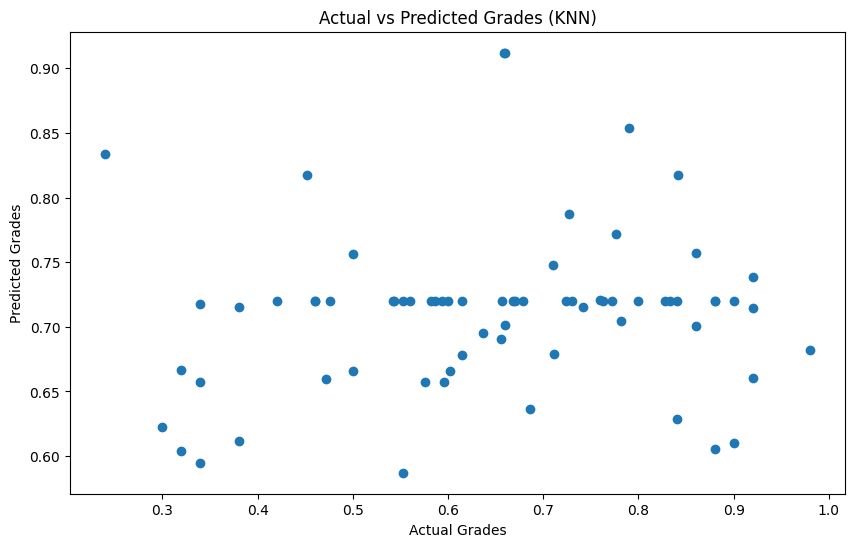

In [90]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn)
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.title('Actual vs Predicted Grades (KNN)')

RMSE = root_mean_squared_error(y_test, y_pred_knn)
print(f'Root Mean Squared Error: {RMSE}')


Root Mean Squared Error: 0.19219270831644467


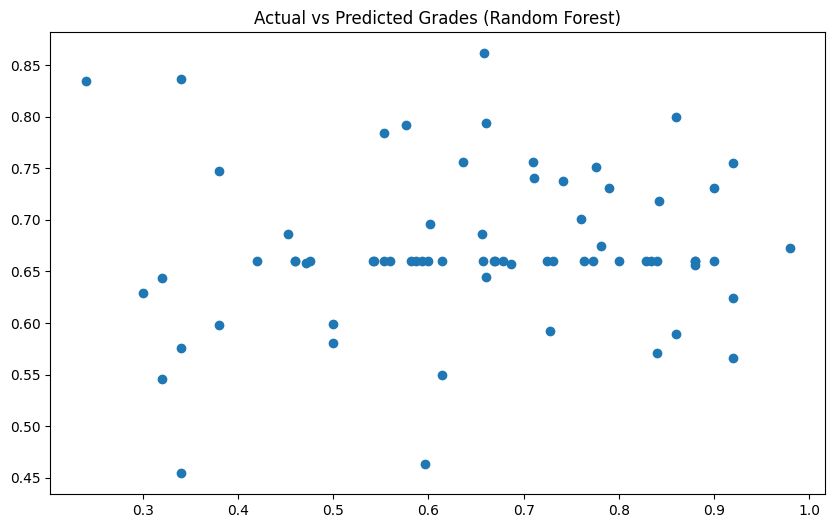

In [91]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf)
plt.title('Actual vs Predicted Grades (Random Forest)')
RMSE = root_mean_squared_error(y_test, y_pred_rf)
print(f'Root Mean Squared Error: {RMSE}')


Root Mean Squared Error: 0.18809111478984628


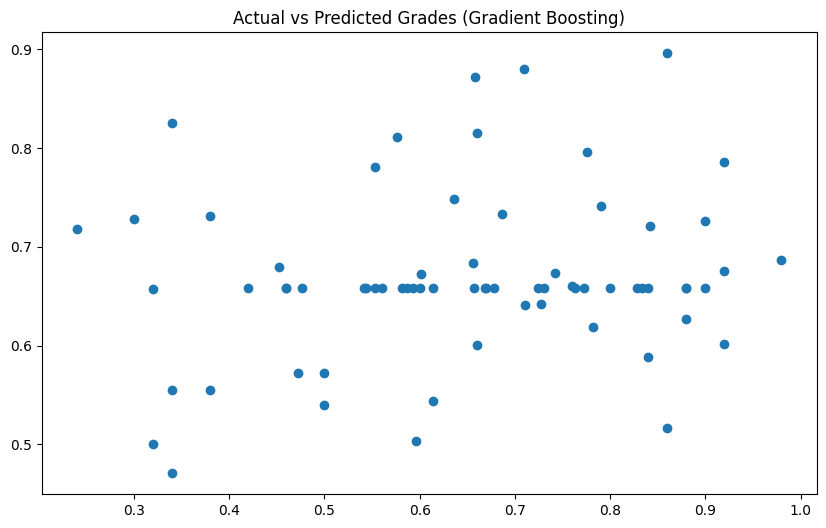

In [92]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb)
plt.title('Actual vs Predicted Grades (Gradient Boosting)')
RMSE = root_mean_squared_error(y_test, y_pred_gb)
print(f'Root Mean Squared Error: {RMSE}')

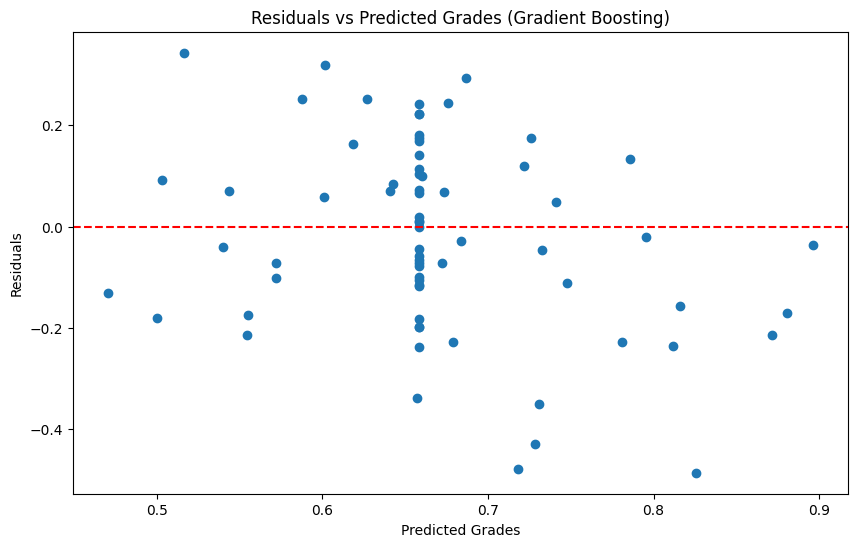

In [93]:
# plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gb, y_test - y_pred_gb)
plt.xlabel('Predicted Grades')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Grades (Gradient Boosting)')
plt.axhline(y=0, color='r', linestyle='--')


Root Mean Squared Error: 0.17220165094106318


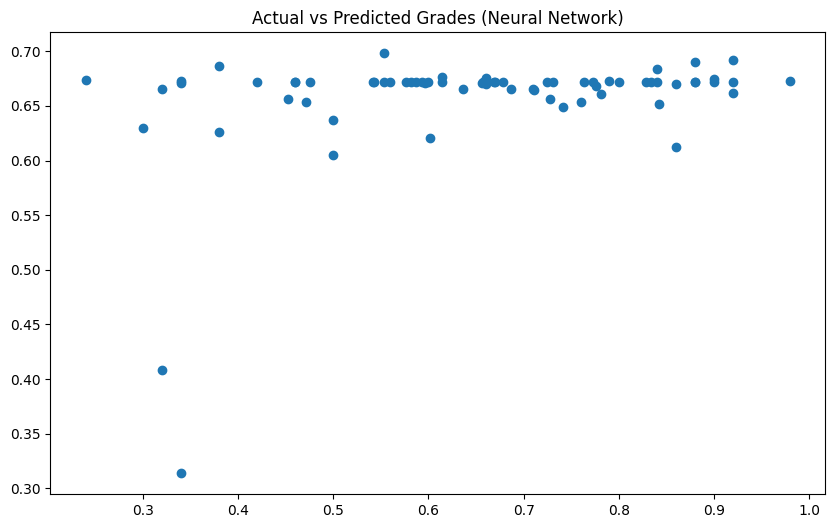

In [94]:
nn = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn)
plt.title('Actual vs Predicted Grades (Neural Network)')
RMSE = root_mean_squared_error(y_test, y_pred_nn)
print(f'Root Mean Squared Error: {RMSE}')

/Users/joannachou/Coding/CSC313/313-Data-Mining/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3896 - root_mean_squared_error: 0.6180 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0483 - root_mean_squared_error: 0.2187 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2049
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0423 - root_mean_squared_error: 0.2054 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2041
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0396 - root_mean_squared_error: 0.1990 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1767
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0358 - root_mean_squared_error: 0.1890 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1793
Epoch 6/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0388 - root_mean_squared_error: 0.1967 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 7/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 - ro

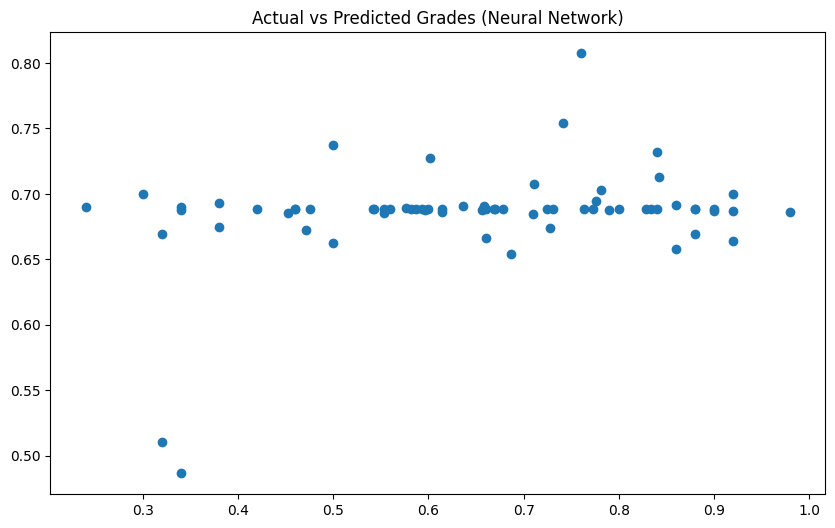

In [95]:
# Define the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['root_mean_squared_error'])

history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.2, verbose=1)

y_pred_nn = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn)
plt.title('Actual vs Predicted Grades (Neural Network)')
RMSE = root_mean_squared_error(y_test, y_pred_nn)
print(f'Root Mean Squared Error: {RMSE}')

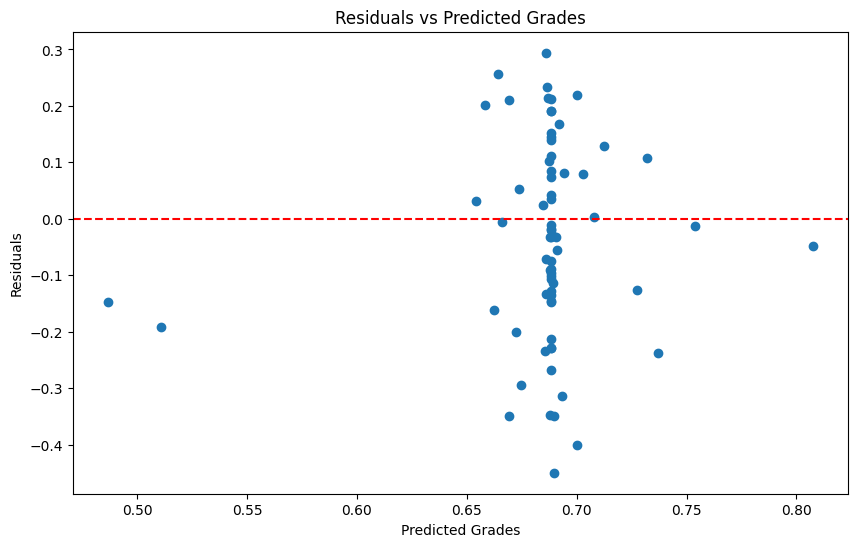

In [96]:
# plot residuals
y_pred_nn = y_pred_nn.flatten()
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_nn
plt.scatter(y_pred_nn, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Grades')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Grades')
plt.show()


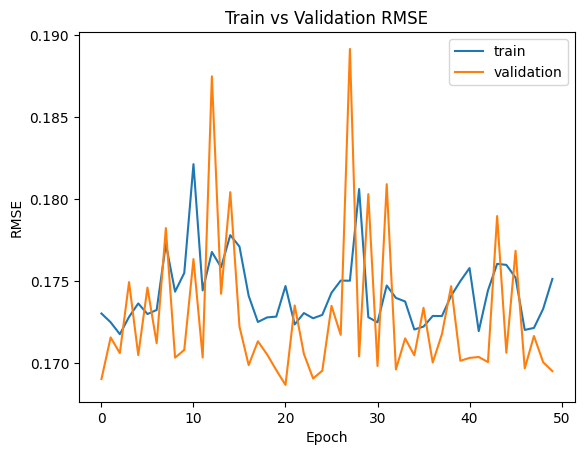

In [97]:
# plot train vs test RMSE
plt.plot(history.history['root_mean_squared_error'][200:], label='train')
plt.plot(history.history['val_root_mean_squared_error'][200:], label='validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE')
plt.show()

## Attempting TFIDF

In [98]:
df_max.head()

SubjectID  AssignmentID  ProblemID  Attempts  Score  \
0  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          1         8    1.0   
1  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          3         6    1.0   
2  036ad3e516c5bf3a4b3be35b137bcbb8         439.0          5         7    1.0   
3  036ad3e516c5bf3a4b3be35b137bcbb8         439.0         12         2    1.0   
4  036ad3e516c5bf3a4b3be35b137bcbb8         439.0         13        17    1.0   

   X-Grade                                        Requirement  If/Else  \
0    0.772  Write a function in Java that implements the f...      1.0   
1    0.772  Write a function in Java that implements the f...      1.0   
2    0.772  Write a function in Java that implements the f...      1.0   
3    0.772  Write a function in Java that implements the f...      1.0   
4    0.772  Write a function in Java that implements the f...      1.0   

   NestedIf  While  ...  LogicCompareNum  LogicBoolean  StringFormat  \
0       NaN    NaN  ...              1.0           NaN           NaN   
1       1.0    NaN  ...              1.0           1.0           NaN   
2       1.0    NaN  ...              NaN           1.0           NaN   
3       1.0    NaN  ...              1.0           1.0           NaN   
4       1.0    NaN  ...              1.0           1.0           NaN   

   StringConcat  StringIndex  StringLen  StringEqual  CharEqual  ArrayIndex  \
0           NaN          NaN        NaN          NaN        NaN         NaN   
1           NaN          NaN        NaN          NaN        NaN         NaN   
2           NaN          NaN        NaN          NaN        NaN         NaN   
3           NaN          NaN        NaN          NaN        NaN         NaN   
4           NaN          NaN        NaN          NaN        NaN         NaN   

   DefFunction  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [99]:
## find average score and attempts per problem
df_problem_avg = df_max.groupby(['AssignmentID','ProblemID', 'Requirement'])[['Score', 'Attempts']].mean().reset_index()

In [100]:
## problem wording preprocessing
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def custom_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemma.lemmatize(w.lower()) for w in tokens if w not in stop_words]
    return tokens

/Users/joannachou/Coding/CSC313/313-Data-Mining/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


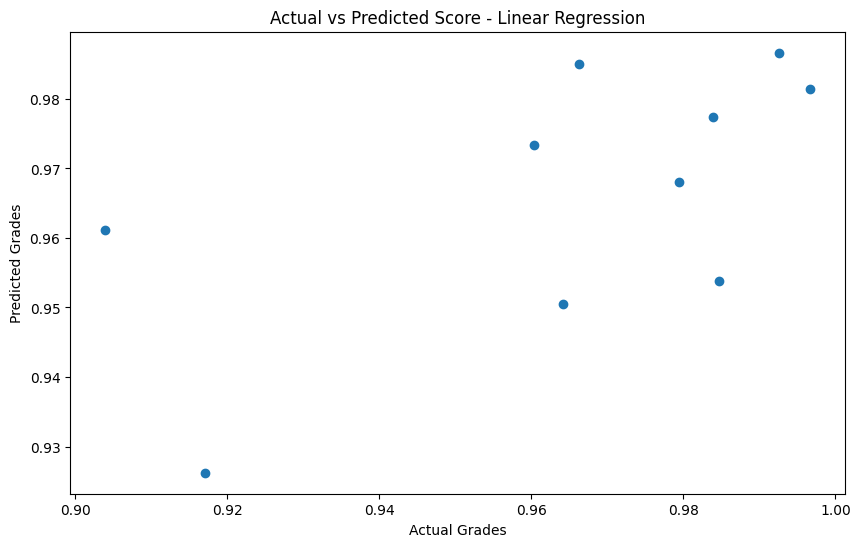

Root Mean Squared Error: 0.02335622678375073


In [101]:
#X = vectorizer.fit_transform(df_problem_avg['Requirement'])
#df_problem_avg['tokenized'] = vectorizer.fit_transform(df_problem_avg['Requirement']).toarray().tolist()

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
mms = MinMaxScaler()
X_text = vectorizer.fit_transform(df_problem_avg['Requirement']).toarray()  # Convert to NumPy array
med = df_problem_avg['Score'].median()
df_problem_avg['score_cat'] = df_problem_avg['Score'].apply(lambda x: 1 if x > med else 0)

# Add additional numerical features
#X_attempts = df_problem_avg[['Attempts']].values
X_attempts = mms.fit_transform(df_problem_avg[['Attempts']])

X = np.hstack((X_text, X_attempts))

y_cat = df_problem_avg['score_cat']
y = df_problem_avg['Score']
#X = df_problem_avg[['tokenized', 'Attempts']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.title('Actual vs Predicted Score - Linear Regression')
plt.show()
RMSE = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {RMSE}')

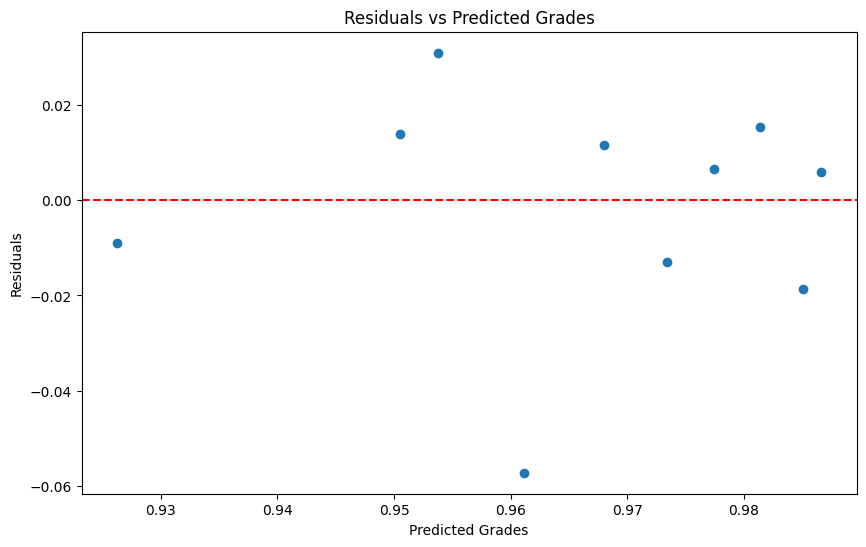

In [102]:
# plot residuals

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel('Predicted Grades')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Grades')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

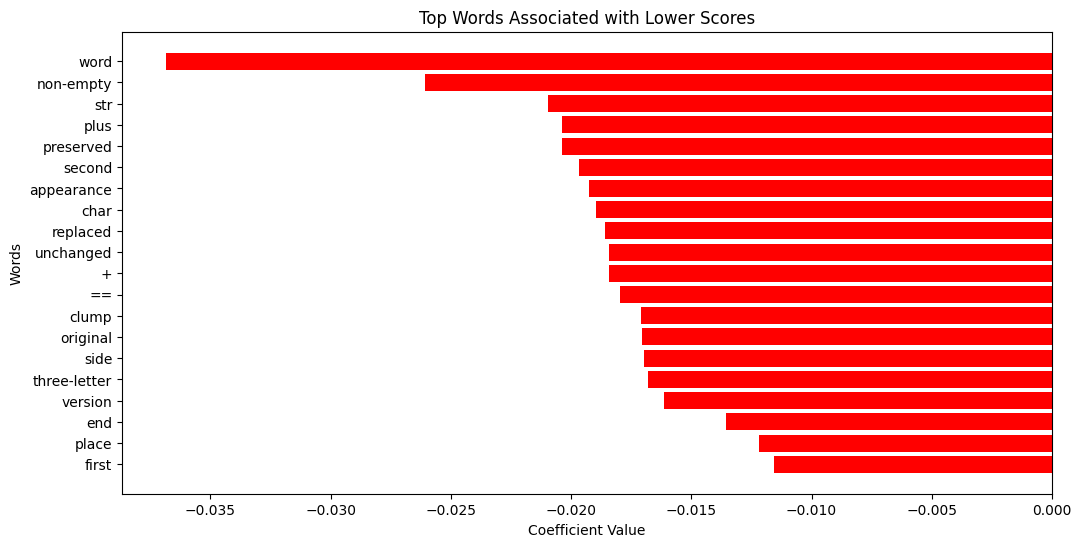

In [103]:
feature_names = vectorizer.get_feature_names_out()

# Get model coefficients
coefficients = model.coef_[:-1]  # Exclude the last coefficient (Attempts)

# Create a DataFrame for analysis
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by most negative coefficients (words that lead to worse scores)
feature_importance = feature_importance.sort_values(by='Coefficient')

# Display the top negative words
top_negative_words = feature_importance.head(20)

# Plot the results
plt.figure(figsize=(12, 6))
plt.barh(top_negative_words['Feature'], top_negative_words['Coefficient'], color='red')
plt.xlabel('Coefficient Value')
plt.ylabel('Words')
plt.title('Top Words Associated with Lower Scores')
plt.gca().invert_yaxis()
plt.show()

In [104]:
df_problem_avg[df_problem_avg['Requirement'].str.contains('word', case=False, na=False)]#['Requirement'].tolist()

AssignmentID  ProblemID  \
21         492.0         32   
25         492.0         37   

                                          Requirement     Score  Attempts  \
21  Write a function in Java that implements the f...  0.890000  6.603333   
25  Given two strings, return true if either of th...  0.984631  3.859813   

    score_cat  
21          0  
25          1

In [105]:
df_problem_avg[df_problem_avg['Requirement'].str.contains('word', case=False, na=False)]['Requirement'].tolist()[0]

'Write a function in Java that implements the following logic: Given a string str and a non-empty word, return a version of the original string where all chars have been replaced by pluses (+), except for appearances of the word which are preserved unchanged.'

**This problem has the worst performance**

Root Mean Squared Error: 0.027829304839163106


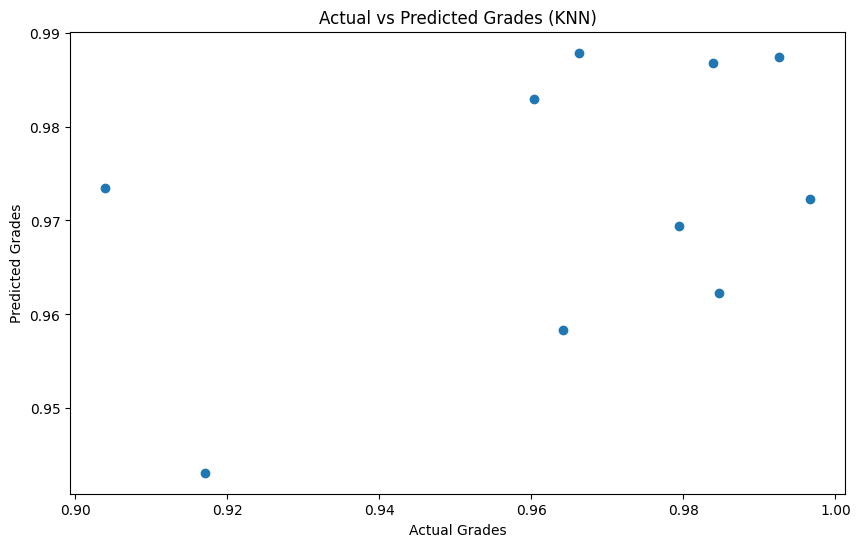

In [106]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn)
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.title('Actual vs Predicted Grades (KNN)')
RMSE = root_mean_squared_error(y_test, y_pred_knn)
print(f'Root Mean Squared Error: {RMSE}')